## Hopper Data Analysis Exercise
#### Adesh Kadambi | June 23, 2019
___

First I will import all standard dependecies and import the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

boscun = pd.read_csv('BOS_CUN_trips1M.csv')

In [2]:
boscun.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,origin,destination,departure,return,outbounddurationminutes,outboundstops,returndurationminutes,returnstops,availableseats,cabinclass,paxtype,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,BOS,CUN,1394789400,1395503700,375,1,391,1,6,E,ADT,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,BOS,CUN,1394829000,1395498600,380,1,363,1,9,E,ADT,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,BOS,CUN,1394804580,1395518400,368,1,417,1,1,E,ADT,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,BOS,CUN,1394789400,1395498600,375,1,363,1,8,E,ADT,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,BOS,CUN,1394789400,1395518400,495,1,417,1,1,E,ADT,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


In [3]:
boscun.nunique()

messageid                  36411
tripindex                   7116
received                   32755
currency                       1
total                      12656
tax                         1344
surcharge                      1
source                         2
merchant                      12
majorcarrierid                15
origin                         1
destination                    1
departure                  13339
return                     11964
outbounddurationminutes      924
outboundstops                  4
returndurationminutes        954
returnstops                    4
availableseats                10
cabinclass                     4
paxtype                        1
refundable                     2
triptimestamp              32713
receiveddate                  55
received_odate                58
departure_odate              387
return_ddate                 405
los2                          96
departure_dow                  7
return_dow                     7
includes_s

Columns that only have one unique value will be dropped in order to improve interpretability. Tax will also be dropped from the table because it is a standard charge dependent on the total price. 

In [4]:
boscun.drop(['currency', 'surcharge', 'origin', 'destination', 'paxtype', 'tax', 'includes_sns'], axis=1, inplace=True)
boscun.sort_values(by=['messageid', 'tripindex'], inplace=True)

I am inferring that the time delta between booking a ticket and departure is an important factor in the final price of the ticket (i.e. buying a ticket closer to departure is more expensive).

In [5]:
boscun['tminus'] = boscun['departure']-boscun['received']
boscun.drop(['receiveddate','received_odate', 'departure_odate', 'return_ddate', 'triptimestamp'], axis=1, inplace=True)

Assigning number values for all categorical data in order to perform feature selection (cannot take in strings, etc).

In [6]:
boscun['cabinclass'] = boscun.groupby(['cabinclass']).ngroup()
boscun['majorcarrierid'] = boscun.groupby(['majorcarrierid']).ngroup()
boscun['source'] = boscun.groupby(['source']).ngroup()
boscun['merchant'] = boscun.groupby(['merchant']).ngroup()
boscun['messageid'] = boscun.groupby(['messageid']).ngroup()

RandomForestRegressor model chosen because its a forecasting model. Although this method seems to have a bias towards the importance of continuous features, it is a fast calculation and easy to implement (one command).

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from tabulate import tabulate

y = boscun.total
X = boscun.drop(['total', 'messageid', 'tripindex'], axis=1)

clf = RandomForestRegressor(random_state=0, n_jobs=-1)
model = clf.fit(X, y)

In [8]:
headers = ["name", "score"]
values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                           score
departure                0.442145
return                   0.26045
returndurationminutes    0.0495098
cabinclass               0.0437195
majorcarrierid           0.0355936
return_dow               0.0275069
outbounddurationminutes  0.0251513
tminus                   0.023537
received                 0.0205385
departure_dow            0.0177369
availableseats           0.0174306
los2                     0.011208
returnstops              0.00778893
source                   0.00615036
outboundstops            0.00538027
refundable               0.00529798
merchant                 0.000854784


___
#### Initial Conclusions:
- From feature importance, it can be seen that price is mostly dependent (0.928) on the top 9 features. 
- To improve both efficieny and interpretability of future models, any features below an importance of 0.020 (i.e. weak correlation) will be removed prior to further analysis. 
- As a result, the features that will be considered are: '`departure`', '`return`', '`returndurationminutes`', '`cabinclass`', '`majorcarrierid`', '`return_dow`', '`outbounddurationminutes`', '`tminus`', and '`received`'.
___

In [9]:
boscun.head()

,messageid,tripindex,received,total,source,merchant,majorcarrierid,departure,return,outbounddurationminutes,outboundstops,returndurationminutes,returnstops,availableseats,cabinclass,refundable,los2,departure_dow,return_dow,tminus
161328,0,0,1380989352,795.95,1,9,0,1385235600,1385729400,405,1,550,1,1,1,False,6,6,5,4246248
161329,0,1,1380989352,780.95,1,9,3,1385206380,1385761620,554,1,466,1,9,1,False,6,6,5,4217028
161330,0,2,1380989352,1048.95,1,9,3,1385226300,1385753580,273,0,238,0,3,1,False,6,6,5,4236948
161331,0,3,1380989352,835.95,1,9,0,1385222700,1385729400,620,1,550,1,1,1,False,6,6,5,4233348
161332,0,4,1380989352,852.15,1,9,5,1385204400,1385728800,795,2,768,2,9,1,False,6,6,5,4215048


In [10]:
from datetime import datetime, timedelta

boscun['departure'] = boscun['departure'].apply(lambda x:datetime.utcfromtimestamp(x) - timedelta(hours=4))
boscun['received'] = boscun['received'].apply(lambda x:datetime.utcfromtimestamp(x) - timedelta(hours=4))
boscun['return'] = boscun['return'].apply(lambda x:datetime.utcfromtimestamp(x) - timedelta(hours=5))
boscun['tminus'] = boscun['departure'] - boscun['received']
boscun['tminus'] = boscun['tminus'].apply(lambda x: x.total_seconds()/(60*60*24))

In [11]:
boscun.drop(['departure_dow', 'availableseats', 'los2', 'returnstops', 'source', 'outboundstops', 'refundable', 'merchant'], axis=1, inplace=True)

In [12]:
boscun.head()

,messageid,tripindex,received,total,majorcarrierid,departure,return,outbounddurationminutes,returndurationminutes,cabinclass,return_dow,tminus
161328,0,0,2013-10-05 12:09:12,795.95,0,2013-11-23 15:40:00,2013-11-29 07:50:00,405,550,1,5,49.146389
161329,0,1,2013-10-05 12:09:12,780.95,3,2013-11-23 07:33:00,2013-11-29 16:47:00,554,466,1,5,48.808194
161330,0,2,2013-10-05 12:09:12,1048.95,3,2013-11-23 13:05:00,2013-11-29 14:33:00,273,238,1,5,49.038750
161331,0,3,2013-10-05 12:09:12,835.95,0,2013-11-23 12:05:00,2013-11-29 07:50:00,620,550,1,5,48.997083
161332,0,4,2013-10-05 12:09:12,852.15,5,2013-11-23 07:00:00,2013-11-29 07:40:00,795,768,1,5,48.785278


In [13]:
boscun.describe()

,messageid,tripindex,total,majorcarrierid,outbounddurationminutes,returndurationminutes,cabinclass,return_dow,tminus
count,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06,1.202445e+06
mean,1.846817e+04,2.235687e+02,6.742877e+02,8.173848e+00,4.525631e+02,4.461777e+02,9.996965e-01,3.372046e+00,1.009971e+02
std,1.058052e+04,7.994908e+02,2.787050e+02,4.433219e+00,1.409949e+02,1.453302e+02,4.343844e-02,2.267653e+00,6.702549e+01
min,0.000000e+00,0.000000e+00,3.203700e+02,0.000000e+00,2.610000e+02,2.350000e+02,0.000000e+00,0.000000e+00,9.988426e-03
25%,9.377000e+03,1.000000e+01,4.719500e+02,5.000000e+00,3.850000e+02,3.910000e+02,1.000000e+00,1.000000e+00,4.977424e+01
50%,1.848000e+04,2.300000e+01,5.913700e+02,1.100000e+01,4.150000e+02,4.180000e+02,1.000000e+00,4.000000e+00,8.751470e+01
75%,2.765200e+04,3.900000e+01,7.933700e+02,1.200000e+01,4.950000e+02,4.850000e+02,1.000000e+00,6.000000e+00,1.453888e+02
max,3.641000e+04,7.115000e+03,6.523740e+03,1.400000e+01,1.700000e+03,1.712000e+03,3.000000e+00,6.000000e+00,4.110972e+02


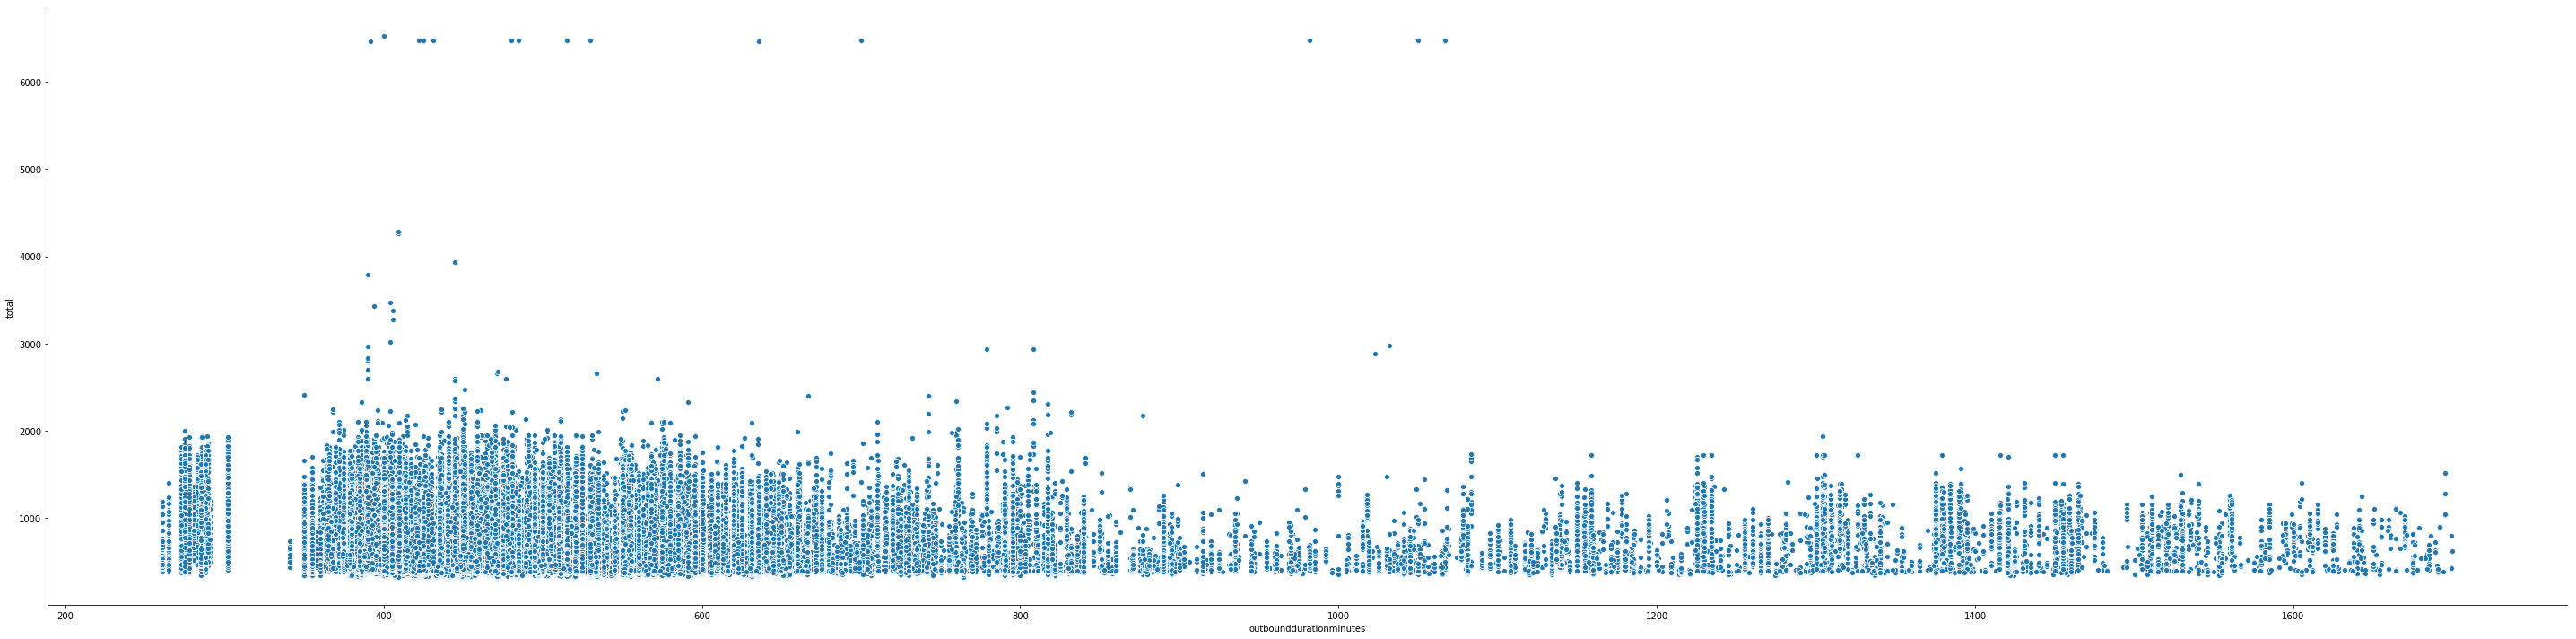

In [14]:
sns.relplot(x="outbounddurationminutes", y="total", data=boscun, height=10, aspect=4);

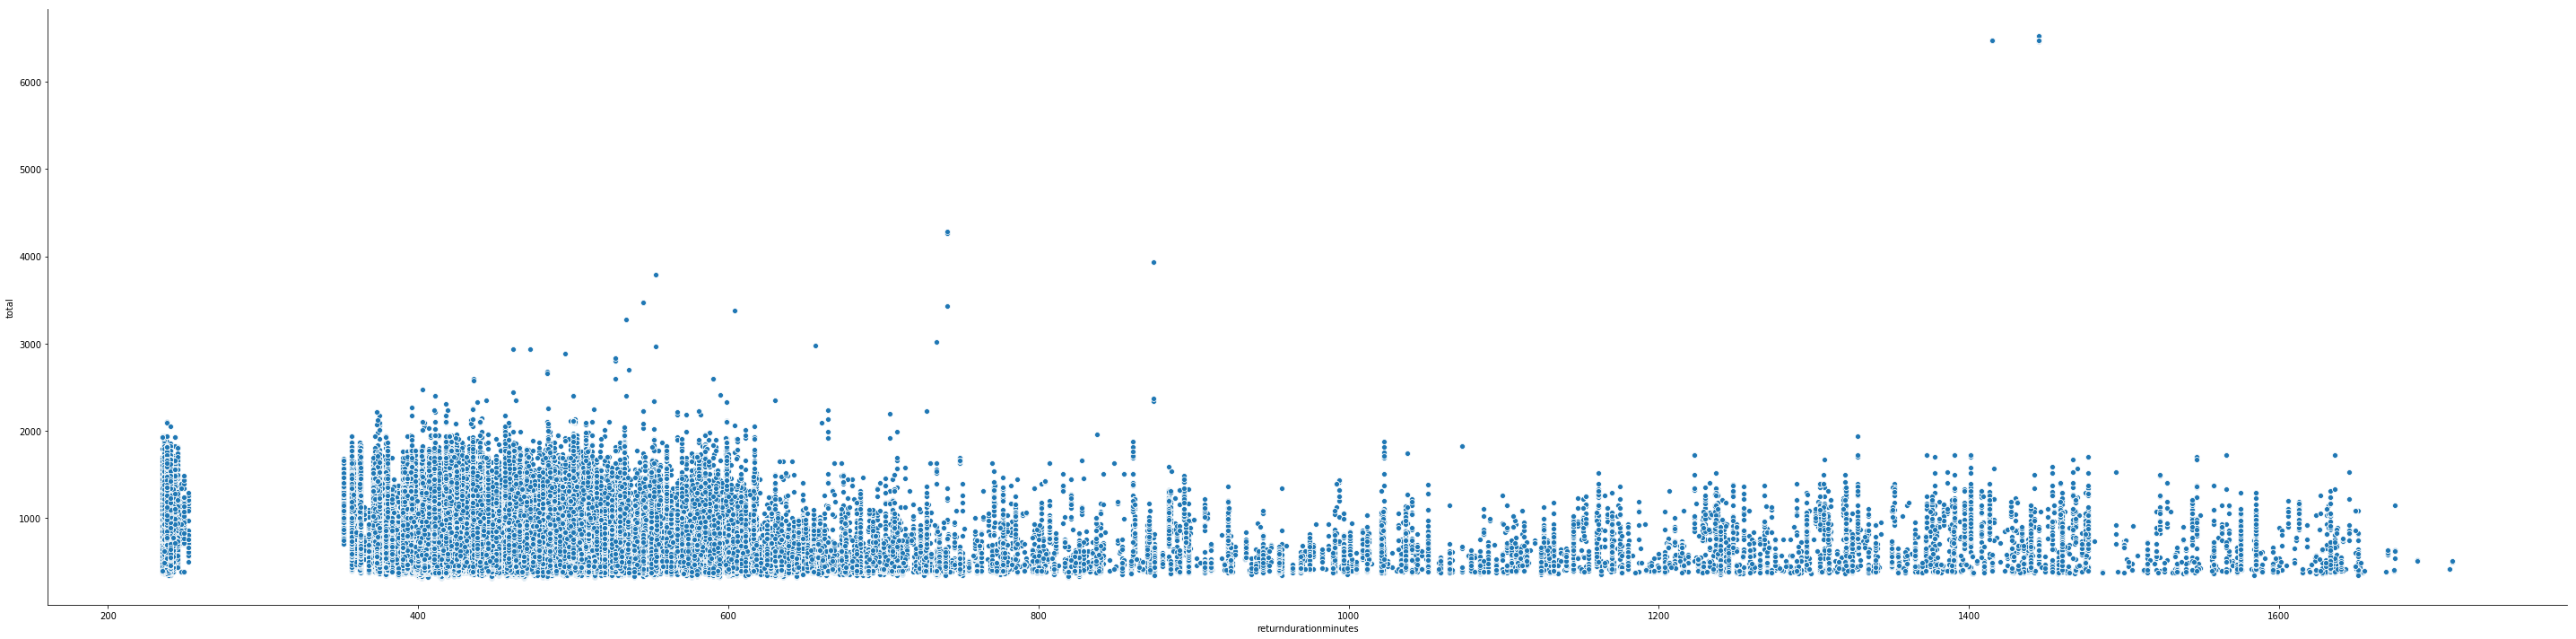

In [15]:
sns.relplot(x="returndurationminutes", y="total", data=boscun, height=10, aspect=4);

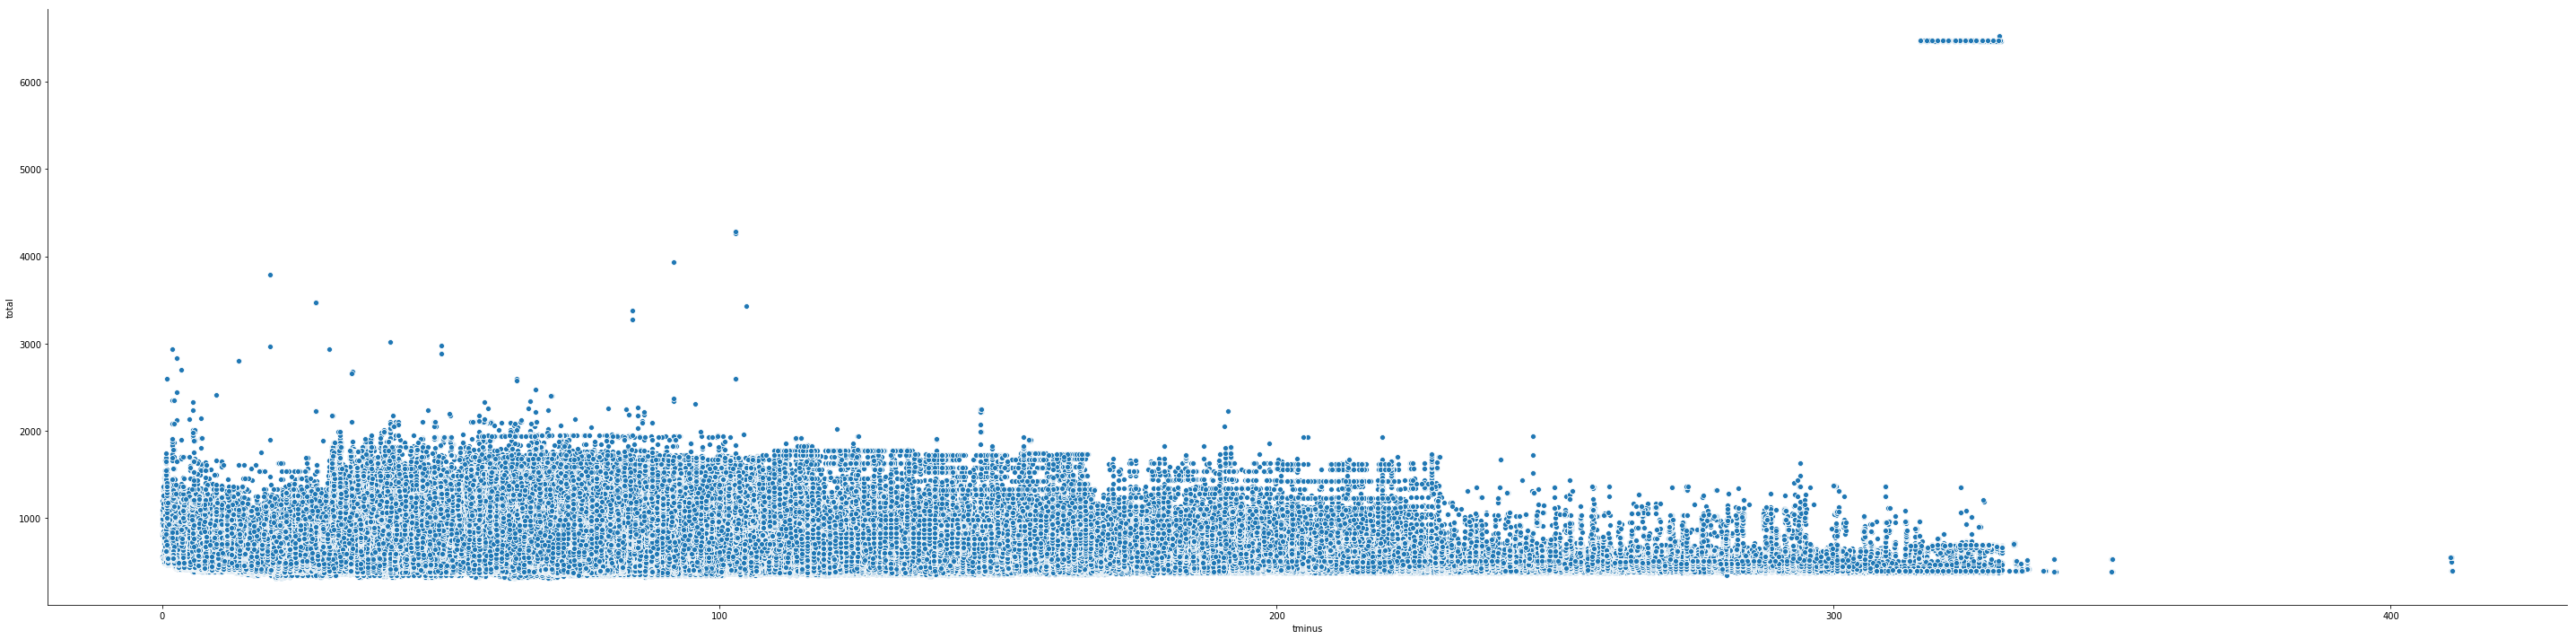

In [16]:
sns.relplot(x="tminus", y="total", data=boscun, height=10, aspect=4);

It can be observed from the above plot that the prices tend to rise roughly 240 days before departure, but dip again in the 30 days before departure (possibly due to cancellations?).

In [17]:
boscun['day'] = boscun['departure'].apply(lambda x: x.weekday())
boscun['month'] = boscun['departure'].apply(lambda x: x.month_name())

In [18]:
boscun['day_ret'] = boscun['return'].apply(lambda x: x.weekday())
boscun['month_ret'] = boscun['return'].apply(lambda x: x.month_name())

month
April        690.940187
August       590.065200
December     870.353212
February     678.838327
January      469.259203
July         526.877762
June         553.309100
March        614.535064
May          523.976119
November     726.643247
October      598.114531
September    546.120509
Name: total, dtype: float64

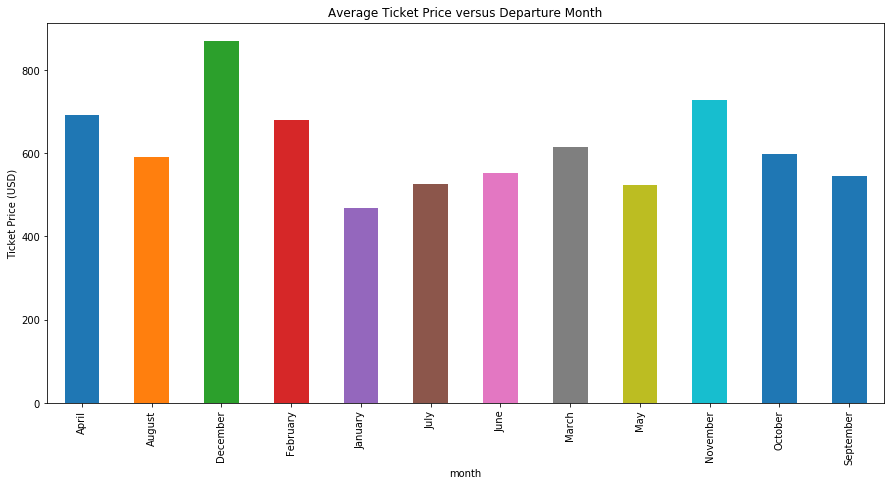

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Average Ticket Price versus Departure Month')
ax.set_ylabel('Ticket Price (USD)')
boscun.groupby(['month']).mean()['total'].plot(ax=ax, kind='bar')
boscun.groupby(['month']).mean()['total']

month_ret
April        701.943979
August       550.677823
December     797.201762
February     662.553979
January      750.934130
July         551.863440
June         534.017532
March        605.557564
May          522.472624
November     607.916707
October      611.868232
September    582.071419
Name: total, dtype: float64

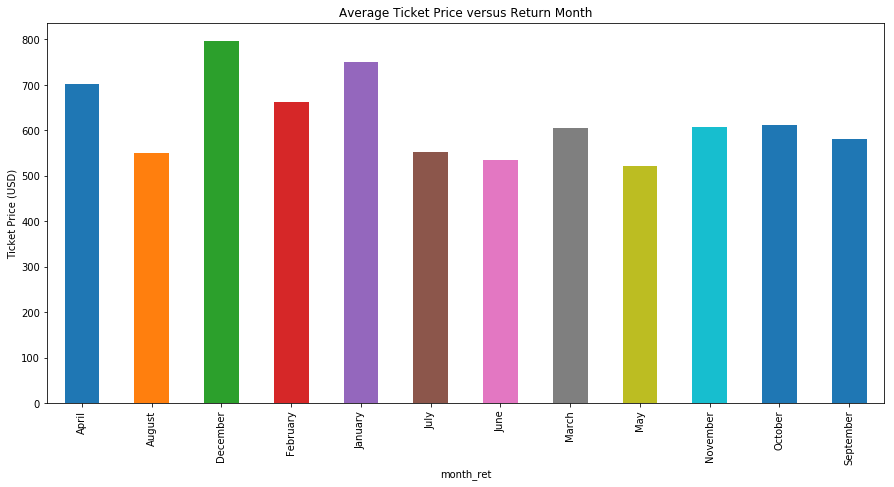

In [20]:
fig3, ax3 = plt.subplots(figsize=(15,7))
ax3.set_title('Average Ticket Price versus Return Month')
ax3.set_ylabel('Ticket Price (USD)')
boscun.groupby(['month_ret']).mean()['total'].plot(ax=ax3, kind='bar')
boscun.groupby(['month_ret']).mean()['total']

day
0    627.900513
1    626.971564
2    677.623847
3    673.031746
4    685.180400
5    707.917809
6    651.500564
Name: total, dtype: float64

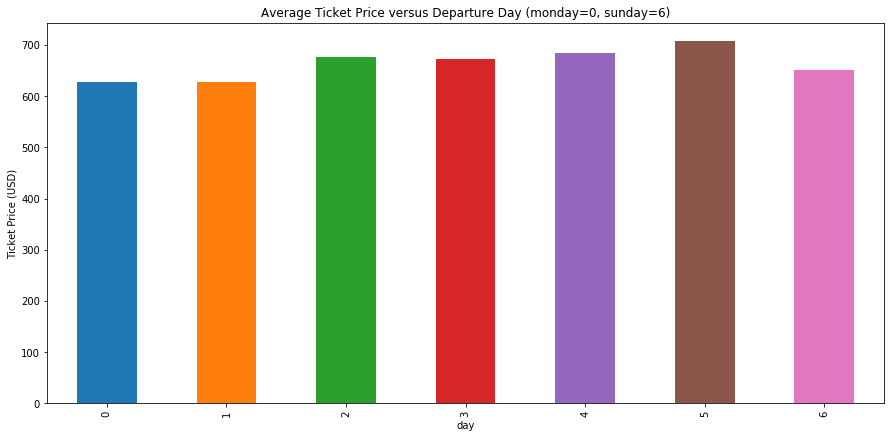

In [21]:
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.set_title('Average Ticket Price versus Departure Day (monday=0, sunday=6)')
ax2.set_ylabel('Ticket Price (USD)')
boscun.groupby(['day']).mean()['total'].plot(ax=ax2, kind='bar')
boscun.groupby(['day']).mean()['total']

day_ret
0    649.155681
1    587.534773
2    651.445512
3    635.992997
4    617.085281
5    724.461680
6    735.656612
Name: total, dtype: float64

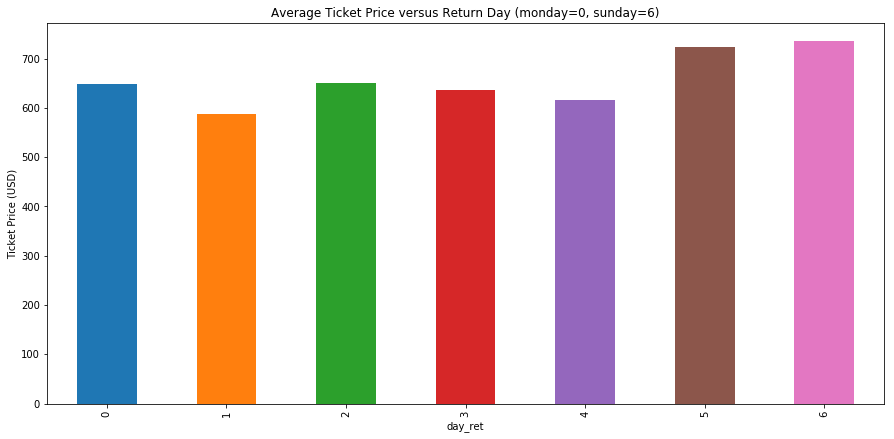

In [22]:
fig4, ax4 = plt.subplots(figsize=(15,7))
ax4.set_title('Average Ticket Price versus Return Day (monday=0, sunday=6)')
ax4.set_ylabel('Ticket Price (USD)')
boscun.groupby(['day_ret']).mean()['total'].plot(ax=ax4, kind='bar')
boscun.groupby(['day_ret']).mean()['total']

In [23]:
boscun['tminus'] = pd.cut(boscun['tminus'], 10)

tminus
(-0.401, 41.119]      622.882180
(41.119, 82.227]      764.542081
(82.227, 123.336]     689.536816
(123.336, 164.445]    636.628298
(164.445, 205.554]    654.237294
(205.554, 246.662]    588.799658
(246.662, 287.771]    555.690218
(287.771, 328.88]     584.002540
(328.88, 369.988]     725.906762
(369.988, 411.097]    535.150000
Name: total, dtype: float64

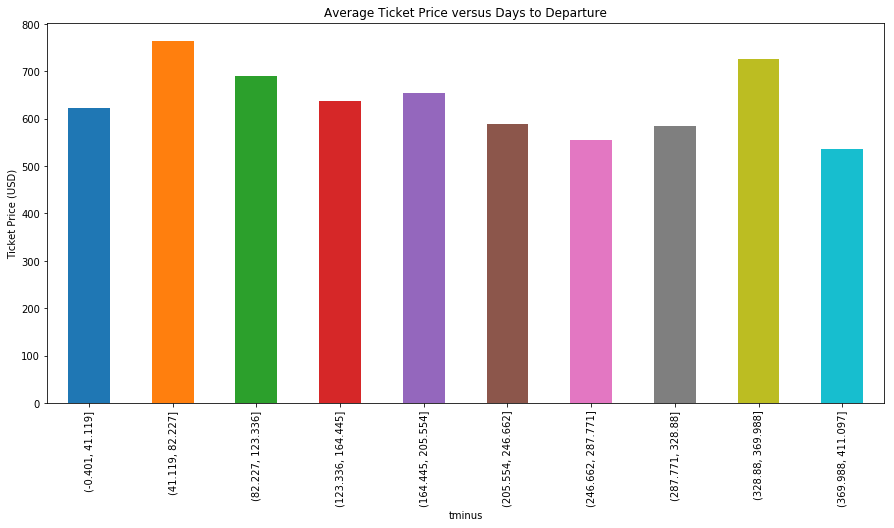

In [24]:
fig5, ax5 = plt.subplots(figsize=(15,7))
ax5.set_title('Average Ticket Price versus Days to Departure')
ax5.set_ylabel('Ticket Price (USD)')
boscun.groupby(['tminus']).mean()['total'].plot(ax=ax5, kind='bar')
boscun.groupby(['tminus']).mean()['total']

___
### Conclusions:
- On average, it is cheapest to fly out to Cancun in the months of January, May, July and September (in ascending order).
- On average, it is cheapest to fly back to Boston in the months of May, June, August and July (in ascending order).
- Although it doesn't make too much of a difference which day you leave, it is cheapest to return on a Tuesday.
- The best time to book tickets is >245 days prior to departure where you will expect to pay between 535 USD and 585 USD 

Disclaimer: purely based on historical data.
___
### Possible Future Analysis:
- Time of day vs. total price.
- Days to departure AND day of week vs. total price.
- Map the frequency of flights by airline and map it against price.
- Multicolinearity test to see if variables are interrelated as well.
- **Forecasting/Prediction algorithmns (Holt Winter's Method).**
___

### Consumer Article: Next Stop, Cancun!

Dated: June 23, 2019

Cancun's picture-perfect white sand, clear water beaches, all inclusive resorts, and Mayan cultural experience have made it one of Mexico's - and the world's - favourite tropical destinations. Families, groups of friends and couples from all across the globe choose to travel to Cancun because of its balance between relaxation and endless entertainment options. Being located along the equator, Cancun is warm and sunny for most of the year, reaching temperatures of over 30 degrees Celsius in the summer while staying in the 20s throughout the rest of the year. The only hiccup is hurricane season, which occurs from the months of June to November. 

Based on historical data from 2013/2014, it was found that the best time to plan your trip to Cancun from Boston is in the month of May. This is because the prices are primarily dependent on departure and return dates (approximately 70%). That being said, the cheapest months to fly out are January, May, July, and September, and the cheapest return flights are in the months of May, June, July, and August. Contrary to popular belief, the day you fly out doesn't significantly affect your ticket prices but it was observed that flights returning on Tuesday were the cheapest.

In general, it's cheapest to plan your trip and book your tickets in advance, or atleast 245 days in advance, where average ticket prices were as low as 535USD! Since it's already June 23rd, it's the perfect time to plan your next family vacation for May of next year, but since ticket prices usually drop in the 30 days right before departure, it's still not too late to book that impromptu trip to Cancun with friends next month where you'll expect to pay around 620USD.
___
END